In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape, test.shape

((2190, 13), (730, 12))

# EDA

In [3]:
ignore_cols = ['id']

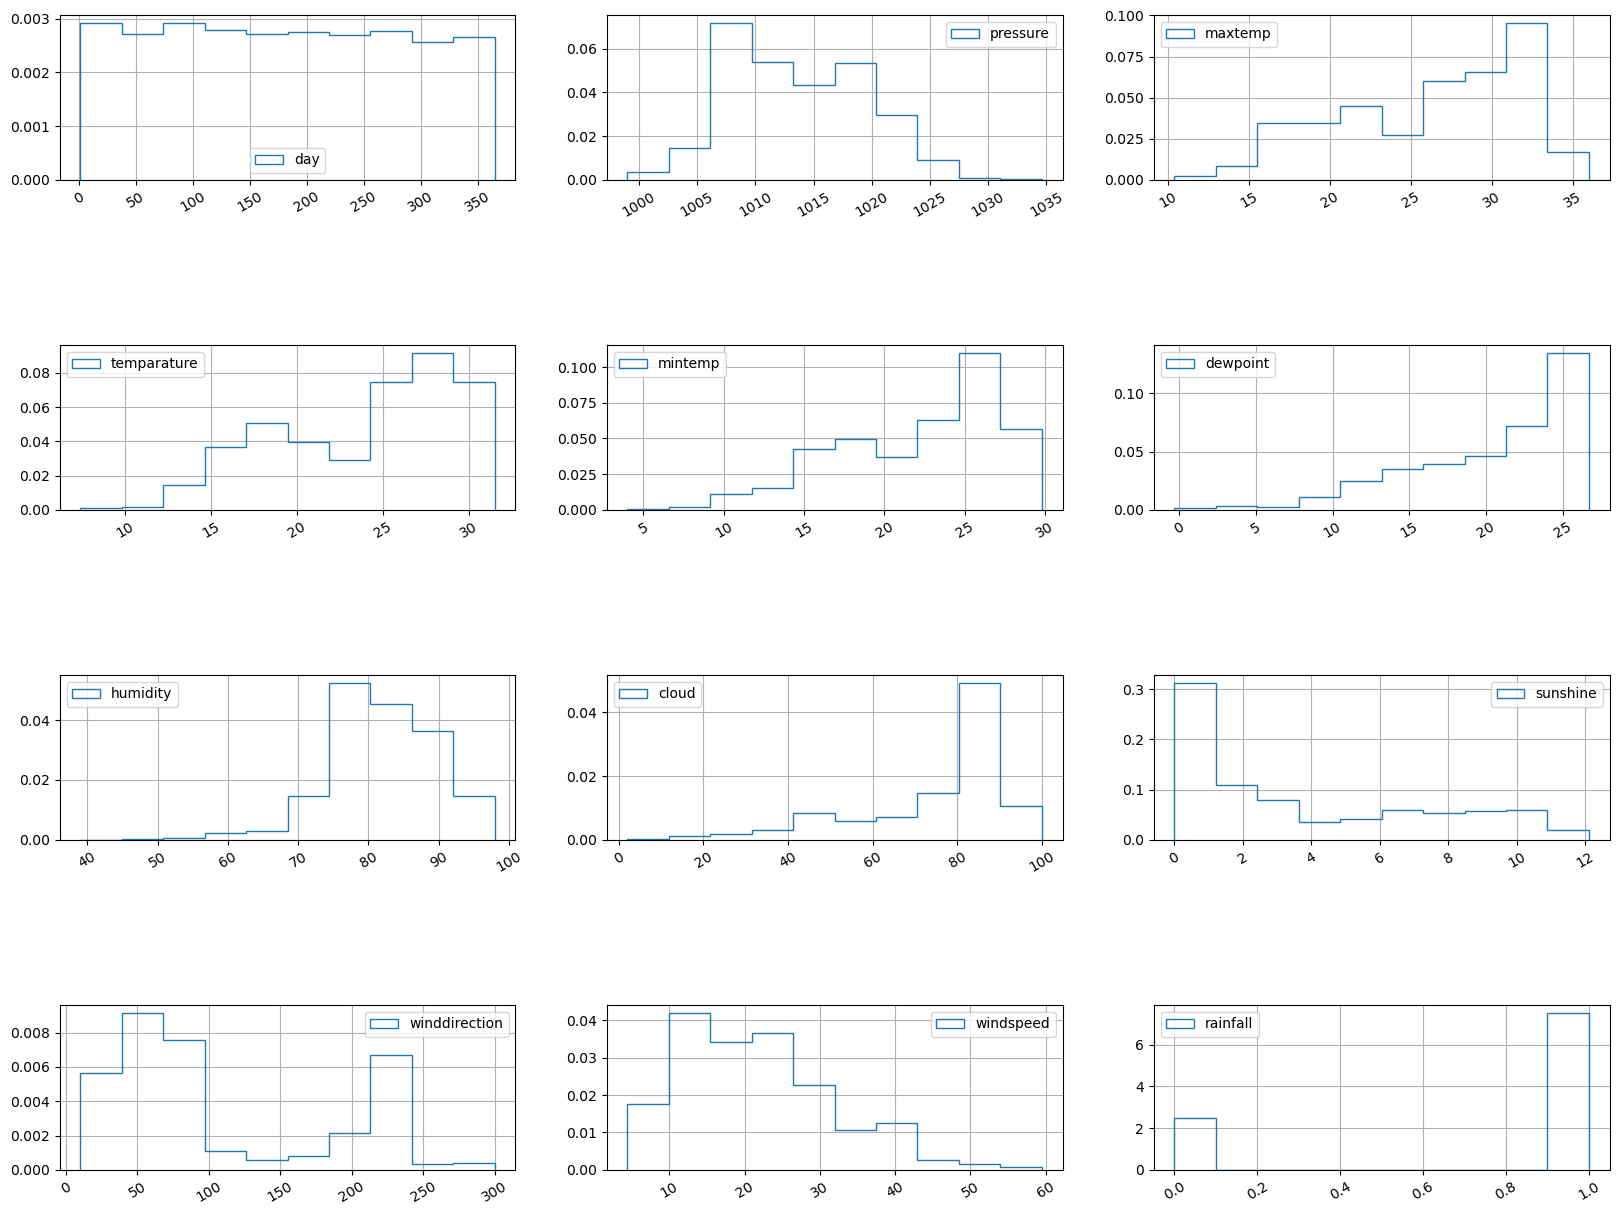

In [4]:
plotcols = [c for c in train.columns if c not in ignore_cols]
ncols = len(plotcols)

nplotrows = (ncols+2) // 3

fig, ax = plt.subplots(nplotrows,3,figsize=(20,15))
fig.subplots_adjust(hspace=1)
axf = ax.flatten()

for i,axi in enumerate(ax.flatten()):
    if i < ncols:
        _,bins,_ = axi.hist(train[plotcols[i]],histtype='step',density=True,label=plotcols[i])
        axi.grid()
        axi.legend()
        axi.tick_params(axis='x', labelrotation=30)
# plt.hist(test[c],bins,density=True);

data anomaly in day of week

<Axes: xlabel='id'>

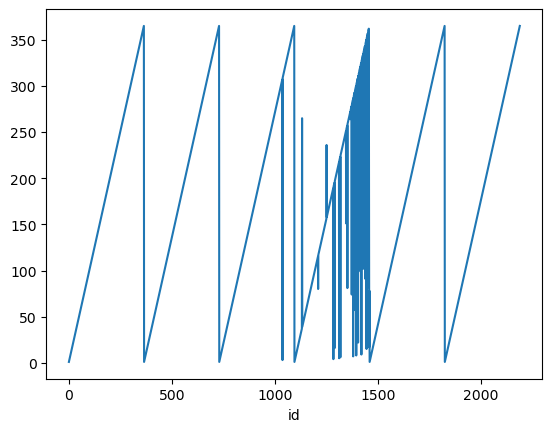

In [5]:
train.set_index('id')['day'].plot()

In [6]:
train['newday'] = train.id.mod(365) + 1

<Axes: xlabel='id'>

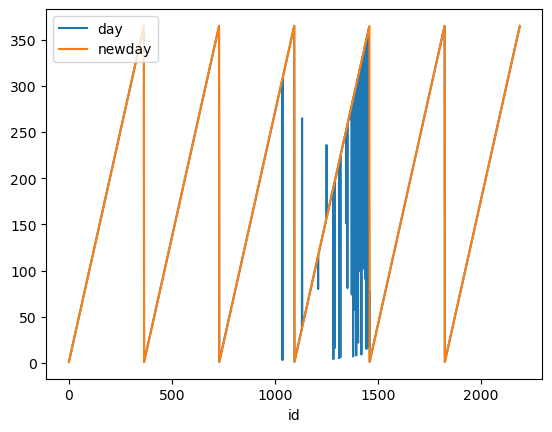

In [7]:
train.set_index('id')[['day','newday']].plot()

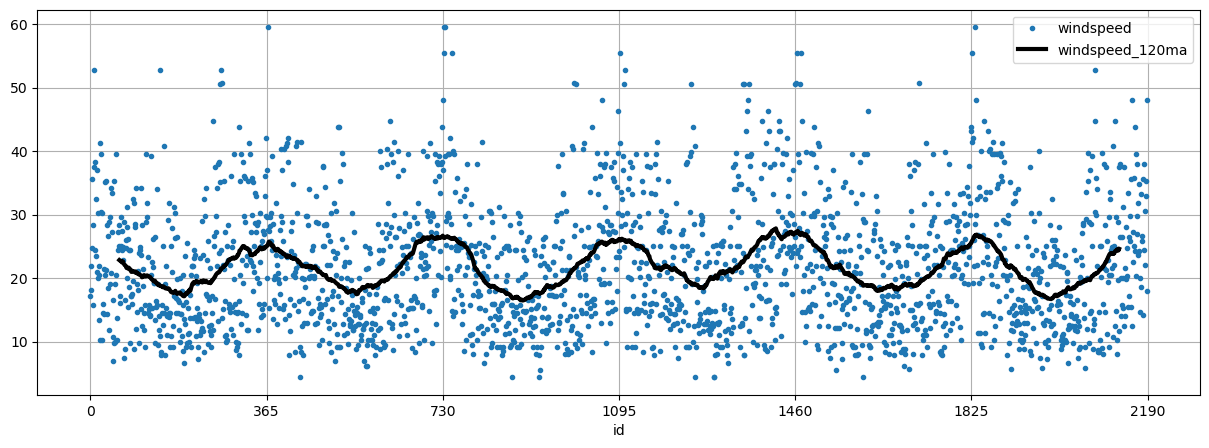

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
label='windspeed'
ma_window=120
xmin,xmax=0,len(train)
train[train.id.between(xmin,xmax)].plot(x='id', y=label, label=label, ax=ax, marker='.', linestyle='')
train[train.id.between(xmin,xmax)].set_index('id')[label].rolling(ma_window,closed='both',center=True).mean().plot(label=f"{label}_{ma_window}ma",ax=ax,color='k',linewidth=3)
ax.legend()
plt.xticks(range(xmin,xmax+1,365))
ax.grid();

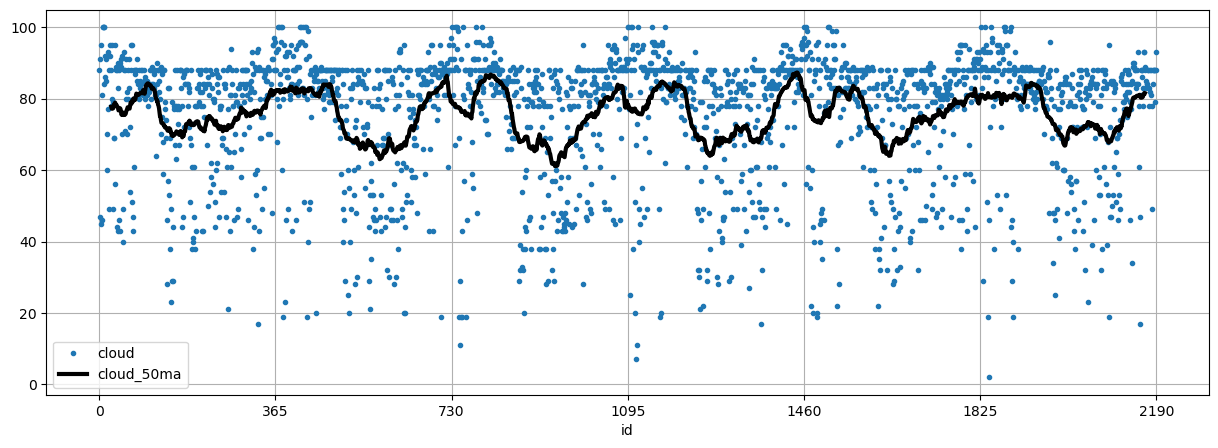

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
label='cloud'
ma_window=50
xmin,xmax=0,len(train)
train[train.id.between(xmin,xmax)].plot(x='id', y=label, label=label, ax=ax, marker='.', linestyle='')
train[train.id.between(xmin,xmax)].set_index('id')[label].rolling(ma_window,closed='both',center=True).mean().plot(label=f"{label}_{ma_window}ma",ax=ax,color='k',linewidth=3)
ax.legend()
plt.xticks(range(xmin,xmax+1,365))
ax.grid();

In [10]:
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf
# import pandas as pd

# # Sample time series data (replace with your data)

# # Create the autocorrelation plot
# plot_acf(data.rainfall, lags=365)  # Adjust 'lags' as needed
# plt.title("Autocorrelation Plot")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")
# plt.show()

# Features

In [12]:
data = train[['id', 'newday', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall']]

### Exploratory Features

In [13]:
data['sinday'] = np.sin(2*np.pi * train.newday / 365)
data['cosday'] = np.cos(2*np.pi * train.newday / 365)

In [14]:
from scipy.stats import pearsonr
data['cloud_ma5'] = data['cloud'].rolling(5,closed='left').mean().bfill()
data['cloud_shift1'] = data.cloud.shift(1).bfill()
# data['cloud_clipped'] = np.select([data.cloud < 25, data.cloud > 85
# data['rainfall_ma60'] = data['rainfall'].rolling(60,closed='left').mean()
pearsonr(data.dropna()['cloud_ma5'],data.dropna().rainfall)

PearsonRResult(statistic=0.19779376033845705, pvalue=9.32813376473582e-21)

In [15]:
label = 'cloud'

data['xdiff'] = data[label].diff(1).fillna(0)

data.groupby(pd.qcut(data.xdiff,5),observed=False).agg(avg=('rainfall',lambda x: x.mean()),
                                             total_days=('rainfall',len),
                                             rain_days=('rainfall',lambda x: np.sum(x==1))
                                            )

,avg,total_days,rain_days
xdiff,,,
"(-81.001, -12.0]",0.361174,443,160
"(-12.0, -3.0]",0.826577,444,367
"(-3.0, 2.0]",0.874419,430,376
"(2.0, 12.0]",0.879545,440,387
"(12.0, 91.0]",0.831409,433,360


In [281]:
label = 'dewpoint'
data.groupby(pd.qcut(data[label],5),observed=False).agg(avg=('rainfall',lambda x: x.mean()),
                                             total_days=('rainfall',len),
                                             rain_days=('rainfall',lambda x: np.sum(x==1))
                                            )

,avg,total_days,rain_days
dewpoint,,,
"(-0.301, 15.6]",0.682540,441,301
"(15.6, 20.1]",0.803204,437,351
"(20.1, 23.3]",0.782609,437,342
"(23.3, 25.3]",0.714000,500,357
"(25.3, 26.7]",0.797333,375,299


In [255]:
data['cloudbins'] = pd.cut(data.cloud,[0,30,40,50,60,70,85,100],include_lowest=True)
data['cloud']
data.groupby(['cloudbins'],observed=False).agg(avg=('rainfall',lambda x: x.mean()),
                                             total_days=('rainfall',len),
                                             rain_days=('rainfall',lambda x: np.sum(x==1))
                                            )

,avg,total_days,rain_days
cloudbins,,,
"(-0.001, 30.0]",0.043478,69,3
"(30.0, 40.0]",0.116667,60,7
"(40.0, 50.0]",0.271739,184,50
"(50.0, 60.0]",0.354331,127,45
"(60.0, 70.0]",0.629139,151,95
"(70.0, 85.0]",0.861250,800,689
"(85.0, 100.0]",0.952441,799,761


In [262]:
data['lowcloud'] = data.cloud <= 30
data['highcloud'] = data.cloud >= 85
data['midcloud'] = np.log10(data.cloud)

In [ ]:
cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='roc_auc')

# Training

In [313]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

params = {
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    
}

def train_xgboost_timeseries(df, target_column, feature_columns, n_splits=5, params=None):
    """
    Trains an XGBoostClassifier on time-series data.
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing time-series data.
    target_column (str): The name of the target column.
    n_splits (int): Number of splits for time-series cross-validation.
    params (dict): Hyperparameters for XGBoostClassifier.
    
    Returns:
    model (xgb.XGBClassifier): Trained XGBoost classifier.
    """
    
    df = df.sort_values(by='id')
    X = df[feature_columns]
    y = df[target_column]
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=0)
    
    model = xgb.XGBClassifier(**params)
    # model =  LogisticRegression(random_state=10)
    
    accs = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # print("Fold: ", X_train.index.min(),X_train.index.max())
        
        # scaler = MinMaxScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = roc_auc_score(y_test, y_pred)
        # print(f'Fold accuracy: {acc:.4f}')
        accs.append(acc)
        
    return y_pred,y_test, model, accs

In [339]:
# for xt in ['pressure', 'maxtemp', 'temparature', 'mintemp',
#        'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
#        'windspeed']:
#     print(xt)
#     ypred,ytest, _, accs = train_xgboost_timeseries(data, target_column="rainfall", feature_columns=[xt],n_splits=5,params=params)
#     print(f"{np.mean(accs):.4f} +- {np.std(accs):.4f}")

In [337]:
ypred,ytest, _, accs = train_xgboost_timeseries(data[0:], target_column="rainfall", feature_columns=["cloud","sunshine"],n_splits=4,params=params)
print(f"{np.mean(accs):.4f} +- {np.std(accs):.4f}")

0.7860 +- 0.0180


In [37]:
train_raw = pd.read_csv("train.csv")
X = train_raw[['cloud']]
y = train_raw.rainfall
kfold=StratifiedKFold(10, shuffle=True, random_state=0)

In [43]:
model = XGBClassifier(random_state=0)
np.mean(cross_val_score(model, X,y, cv=kfold, n_jobs=1, scoring='roc_auc'))

0.8697250280583614

In [44]:
model = TabPFNClassifier(random_state=0)
np.mean(cross_val_score(model, X,y, cv=kfold, n_jobs=1, scoring='roc_auc'))

0.8757014590347924

In [45]:
train_raw = pd.read_csv("train.csv")
X = train_raw[['cloud','sunshine','dewpoint','pressure','temparature']]
y = train_raw.rainfall
kfold=StratifiedKFold(10, shuffle=True, random_state=0)

In [46]:
model = XGBClassifier(random_state=0)
np.mean(cross_val_score(model, X,y, cv=kfold, n_jobs=1, scoring='roc_auc'))

0.8579685746352412

In [47]:
model = TabPFNClassifier(random_state=0)
np.mean(cross_val_score(model, X,y, cv=kfold, n_jobs=1, scoring='roc_auc'))

0.8918630751964084

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier

train_raw = pd.read_csv("train.csv")
X = train_raw
y = train_raw.pop('rainfall')

kfold = StratifiedKFold(10, shuffle=True, random_state=0)

models ={
    'tabpfn': TabPFNClassifier(random_state=0),
    'xgboost': XGBClassifier(n_jobs=4, random_state=0),
}

for m in models:
    model = models[m]
    %time scores = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='roc_auc')
    print(F'{m}: {scores.mean():.5f} ± {scores.std():.5f}')

CPU times: total: 23.8 s
Wall time: 4.36 s
tabpfn: 0.89361 ± 0.02458
CPU times: total: 3.12 s
Wall time: 711 ms
xgboost: 0.86713 ± 0.02887


# DART
unused code for DART. ended up not using because DART only supports regression models, not classification models 

## Create custom columns

In [91]:
from darts import TimeSeries
from darts.dataprocessing.transformers import StaticCovariatesTransformer, InvertibleMapper,Scaler
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.dataprocessing import Pipeline

In [92]:
data = train[['id', 'newday', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall']]

In [93]:
def get_pipeline():
    lst = []
    
    # rescale time series
    scaler = Scaler()
    lst.append(scaler)

    # chain all transformations
    pipeline = Pipeline(lst)
    return pipeline

<Axes: xlabel='id'>

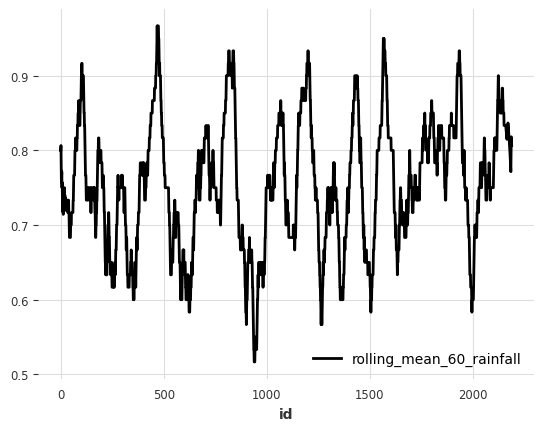

In [228]:
# test moving average functionality
past_covs = TimeSeries.from_dataframe(
    df=data,
    time_col="id",
    value_cols=["temparature","pressure","rainfall"],
)
ma_filter = MovingAverageFilter(window=60)
# past_covs['pressure'].plot()
# ma_filter.filter(past_covs['pressure']).plot()
ma_filter.filter(past_covs['rainfall']).plot()

In [193]:
def get_covariates(
    data,
    time_col,
    past_cols,
    future_cols,
    past_ma_cols=None,
    future_ma_cols=None,
    past_window_sizes=[7, 28],
    future_window_sizes=[7, 28],
):
    past_dict = {}
    future_dict = {}
    
    # initialize transformation pipeline for covariates
    covs_pipe = get_pipeline()
        
    # extract past covariates
    past_covs = TimeSeries.from_dataframe(
        df=data,
        time_col=time_col,
        value_cols=past_cols,
    )
    
    past_covs = covs_pipe.fit_transform(past_covs)

    # extract moving averages of past covariates
    if past_ma_cols is not None:
        for size in past_window_sizes:
            ma_filter = MovingAverageFilter(window=size)
            old_names = [f"rolling_mean_{size}_{col}" for col in past_ma_cols]
            new_names = [f"{col}_ma{size}" for col in past_ma_cols]
            past_ma_covs = ma_filter.filter(past_covs[past_ma_cols]).with_columns_renamed(old_names, new_names)
            past_covs = past_covs.stack(past_ma_covs)
    
    # extract future covariates
    future_covs = TimeSeries.from_dataframe(
        df=data,
        time_col=time_col,
        value_cols=future_cols,
    )
    
    future_covs = covs_pipe.fit_transform(future_covs)
    
    if future_ma_cols is not None:
        for size in future_window_sizes:
            ma_filter = MovingAverageFilter(window=size)
            old_names = [f"rolling_mean_{size}_{col}" for col in future_ma_cols]
            new_names = [f"{col}_ma{size}" for col in future_ma_cols]
            future_ma_covs = ma_filter.filter(future_covs[future_ma_cols]).with_columns_renamed(old_names, new_names) 
            future_covs = future_covs.stack(future_ma_covs)
                
    return past_covs, future_covs

In [194]:
# test = get_covariates(data=data,time_col="id",past_cols=['temparature','pressure'],future_cols=['newday'],
#                past_ma_cols=['temparature'],future_ma_cols=['newday'],past_window_sizes=[7,28],future_window_sizes=[7,28])

In [199]:
# past covariates
past_cols = ['pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed']

# future covariates
future_cols = ["newday"]

# additional past and future covariates from computing the moving averages
past_ma_cols = None
future_ma_cols = None

past_dict, future_dict = get_covariates(data=data,time_col="id",past_cols=past_cols, future_cols=future_cols, past_ma_cols=past_ma_cols, future_ma_cols=future_ma_cols)

In [213]:
print("past covariates:",past_dict.components.tolist())
print("future covariates:",future_dict.components.tolist())

past covariates: ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
future covariates: ['newday']


In [ ]:
TRAINER_CONFIG = {
    # the time series data previously extracted
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,
    
    # time series cross-validation using a rolling forecasting origin
    "forecast_horizon": 16, # the length of the validation set
    "folds": 1, # the number of training sets (setting to 1 means the standard train-validation split)
    
    # the number of previous days to check for zero sales; if all are zero, generate zero forecasts
    "zero_fc_window": 21,
    
    # specify the covariates in a list to include in the model
    # set to None to not use any, and set to 'keep_all' to include everything
    "static_covs": "keep_all", #['store_nbr'], #"keep_all", # specify from ['city', 'state', 'cluster', 'type', 'store_nbr'], will extract all one-hot encoded columns
    "past_covs": "keep_all",
    "future_covs": "keep_all",
}

In [214]:
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.metrics import rmsle
from tqdm.notebook import tqdm as tqdm_notebook
from time import sleep

In [218]:
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,newday
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,2
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,3
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,4
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,361
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,362
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,363
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1,364


In [ ]:
class Trainer:
    def __init__(
        self,
        target_dict,
        pipe_dict,
        id_dict,
        past_dict,
        future_dict,
        forecast_horizon,
        folds,
        zero_fc_window,
        static_covs=None,
        past_covs=None,
        future_covs=None,
    ):
        self.target_dict = target_dict.copy()
        self.pipe_dict = pipe_dict.copy()
        self.id_dict = id_dict.copy()
        self.past_dict = past_dict.copy()
        self.future_dict = future_dict.copy()
        self.forecast_horizon = forecast_horizon
        self.folds = folds
        self.zero_fc_window = zero_fc_window
        self.static_covs = static_covs
        self.past_covs = past_covs
        self.future_covs = future_covs
        
        # set up time series data
        self.setup()
    
    def setup(self):
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Setting up"):
            # keep the specified static covariates
            if self.static_covs != "keep_all":
                target = self.target_dict[fam]
                if self.static_covs is not None:
                    
                    keep_static = [col for col in target[0].static_covariates.columns if col.startswith(tuple(self.static_covs))]
                    static_covs_df = [t.static_covariates[keep_static] for t in target]
                    self.target_dict[fam] = [t.with_static_covariates(d) for t, d in zip(target, static_covs_df)]
                else:
                    self.target_dict[fam] = [t.with_static_covariates(None) for t in target]
            
            # keep the specified past covariates
            if self.past_covs != "keep_all":
                if self.past_covs is not None:
                    self.past_dict[fam] = [p[self.past_covs] for p in self.past_dict[fam]]
                else:
                    self.past_dict[fam] = None
                
            # keep the specified future covariates
            if self.future_covs != "keep_all":
                if self.future_covs is not None:
                    self.future_dict[fam] = [p[self.future_covs] for p in self.future_dict[fam]]
                else:
                    self.future_dict[fam] = None
    
    def clip(self, array):
        return np.clip(array, a_min=0., a_max=None)
    
    def train_valid_split(self, target, length):
        train = [t[:-length] for t in target]
        valid_end_idx = -length + self.forecast_horizon
        if valid_end_idx >= 0:
            valid_end_idx = None
        valid = [t[-length:valid_end_idx] for t in target]
        
        return train, valid
    
    def get_models(self, model_names, model_configs):
        models = {
            "lr": LinearRegressionModel,
            "lgbm": LightGBMModel,
            "cat": CatBoostModel,
            "xgb": XGBModel,
        }
        assert isinstance(model_names, list) and isinstance(model_configs, list),\
        "Both the model names and model configurations must be specified in lists."
        assert all(name in models for name in model_names),\
        f"Model names '{model_names}' not recognized."
        assert len(model_names) == len(model_configs),\
        "The number of model names and the number of model configurations do not match."
        
        if "xgb" in model_names:
            xgb_idx = np.where(np.array(model_names)=="xgb")[0]
            for idx in xgb_idx:
                # change to histogram-based method for XGBoost to get faster training time
                model_configs[idx] = {"tree_method": "hist", **model_configs[idx]}
        
        return [models[name](**model_configs[j]) for j, name in enumerate(model_names)]
    
    def generate_forecasts(self, models, train, pipe, past_covs, future_covs, drop_before):
        if drop_before is not None:
            date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train = [t.drop_before(date) for t in train]
        inputs = {
            "series": train,
            "past_covariates": past_covs,
            "future_covariates": future_covs,
        }
        zero_pred = pd.DataFrame({
            "date": pd.date_range(train[0].end_time(), periods=self.forecast_horizon+1)[1:],
            "sales": np.zeros(self.forecast_horizon),
        })
        zero_pred = TimeSeries.from_dataframe(
            df=zero_pred,
            time_col="date",
            value_cols="sales",
        )
        
        pred_list = []
        ens_pred = [0 for _ in range(len(train))]
        
        for m in models:
            # fit training data to model
            m.fit(**inputs)
            
            # generate forecasts and apply inverse transformations
            pred = m.predict(n=self.forecast_horizon,show_warnings=False, **inputs)
            pred = pipe.inverse_transform(pred)

            # set zero forecasts for target series where the recent observations are 0s
            for j in range(len(train)):
                if train[j][-self.zero_fc_window:].values().sum() == 0:
                    pred[j] = zero_pred
            
            # clip negative forecasts to 0s
            pred = [p.map(self.clip) for p in pred]
            pred_list.append(pred)
            
            # ensemble averaging
            for j in range(len(ens_pred)):
                ens_pred[j] += pred[j] / len(models)

        return pred_list, ens_pred
    
    def metric(self, valid, pred):
        return rmsle(valid, pred, series_reduction=np.mean)
    
    def validate(self, model_names, model_configs, drop_before=None):
        # helper value to align printed text below
        longest_len = len(max(self.target_dict.keys(), key=len))
        
        # store metric values for each model
        model_metrics_history = []
        ens_metric_history = []
        
        for fam in tqdm_notebook(self.target_dict, desc="Performing validation"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # record average metric value over all folds
            model_metrics = []
            ens_metric = 0
            
            for j in range(self.folds):    
                # perform train-validation split and apply transformations
                length = (self.folds - j) * self.forecast_horizon
                train, valid = self.train_valid_split(target, length)
                valid = pipe.inverse_transform(valid)

                # generate forecasts and compute metric
                models = self.get_models(model_names, model_configs)
                pred_list, ens_pred = self.generate_forecasts(models, train, pipe, past_covs, future_covs, drop_before)
                metric_list = [self.metric(valid, pred) / self.folds for pred in pred_list]
                model_metrics.append(metric_list)
                if len(models) > 1:
                    ens_metric_fold = self.metric(valid, ens_pred) / self.folds
                    ens_metric += ens_metric_fold
                
            # store final metric value for each model
            model_metrics = np.sum(model_metrics, axis=0)
            model_metrics_history.append(model_metrics)
            ens_metric_history.append(ens_metric)
            
            # print metric value for each family
            print(
                fam,
                " " * (longest_len - len(fam)),
                " | ",
                " - ".join([f"{model}: {metric:.5f}" for model, metric in zip(model_names, model_metrics)]),
                f" - ens: {ens_metric:.5f}" if len(models) > 1 else "",
                sep="",
            )
            
        # print overall metric value
        cprint(
            "Average RMSLE | "
            + " - ".join([f"{model}: {metric:.5f}" 
                          for model, metric in zip(model_names, np.mean(model_metrics_history, axis=0))])
            + (f" - ens: {np.mean(ens_metric_history):.5f}" if len(models) > 1 else ""),
        )
        
    def ensemble_predict(self, model_names, model_configs, drop_before=None):        
        forecasts = []
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Generating forecasts"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            target_id = self.id_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # generate forecasts
            models = self.get_models(model_names, model_configs)
            pred_list, ens_pred = self.generate_forecasts(models, target, pipe, past_covs, future_covs, drop_before)
            ens_pred = [p.pd_dataframe().assign(**i) for p, i in zip(ens_pred, target_id)]
            ens_pred = pd.concat(ens_pred, axis=0)
            forecasts.append(ens_pred)
            
        # combine all forecasts into one dataframe
        forecasts = pd.concat(forecasts, axis=0)
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names="date")
        
        return forecasts